# CS445: Computational Photography
## Programming Project 4: Image-Based Lighting


## Recovering HDR Radiance Maps 

Load libraries and data

In [ ]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# System imports
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# modify to where you store your project data including utils
datadir = "/content/drive/MyDrive/CS445/Project 4/" 

utilfn = datadir + "utils"
!cp -r "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .

# can change this to your output directory of choice
!mkdir "images"
!mkdir "images/outputs"


# import starter code
import utils
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter

mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘images/outputs’: File exists


### Reading LDR images

You can use the provided samples or your own images.  You get more points for using your own images, but it might help to get things working first with the provided samples.

In [ ]:
# TODO: Replace this with your path and files

imdir = 'samples'
# imfns = ['0024.jpg', '0060.jpg', '0120.jpg', '0205.jpg', '0553.jpg']
# exposure_times = [1/24.0, 1/60.0, 1/120.0, 1/205.0, 1/553.0]
imfns = ['16_image.jpg','64_image.jpg','256_image.jpg']
exposure_times = [1/16.0, 1/64.0, 1/256.0]

ldr_images = []
for f in np.arange(len(imfns)):
  im = read_image(imdir + '/' + imfns[f])
  if f==0:
    imsize = int((im.shape[0] + im.shape[1])/2) # set width/height of ball images
    ldr_images = np.zeros((len(imfns), imsize, imsize, 3))
  ldr_images[f] = cv2.resize(im, (imsize, imsize))

background_image_file = imdir + '/' + 'empty.jpg'
background_image = read_image(background_image_file)



### Naive LDR merging 

Compute the HDR image as average of irradiance estimates from LDR images

In [ ]:
def make_hdr_naive(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) Divide each image by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    2) Return average of above images
    
    
    For further explanation, please refer to problem page for how to do it.
      
    Args:
        ldr_images(np.ndarray): N x H x W x 3  shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            naive ldr merging implementation.
        (np.ndarray): N x H x W x 3  shaped numpy array represending log irradiances
            for each exposures
            
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposures)
    # TO DO
    hdr_image = np.zeros((H,W,3))
    log_irradiances = np.zeros((N,H,W,3))
    images = ldr_images.copy()
    for index in range(N):
      images[index,:,:,:] = images[index,:,:,:]/exposures[index]
      hdr_image[:,:,:] += images[index,:,:,:]/N
      log_irradiances[index,:,:,:] = np.log(ldr_images[index,:,:,:]/exposures[index])
    return hdr_image, log_irradiances



In [ ]:
def display_hdr_image(im_hdr):
    '''
    Maps the HDR intensities into a 0 to 1 range and then displays. 
    Three suggestions to try: 
      (1) Take log and then linearly map to 0 to 1 range (see display.py for example) 
      (2) img_out = im_hdr / (1 + im_hdr)
      (3) HDR display code in a python package 
    '''
    # TO DO
    img_out = im_hdr / (1 + im_hdr)
    plt.imshow(img_out)



<ipython-input-58-688c36537c44>:36: RuntimeWarning: divide by zero encountered in log
  log_irradiances[index,:,:,:] = np.log(ldr_images[index,:,:,:]/exposures[index])


HDR Image


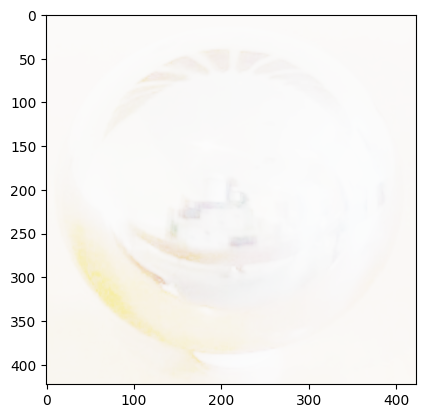

<Figure size 640x480 with 0 Axes>

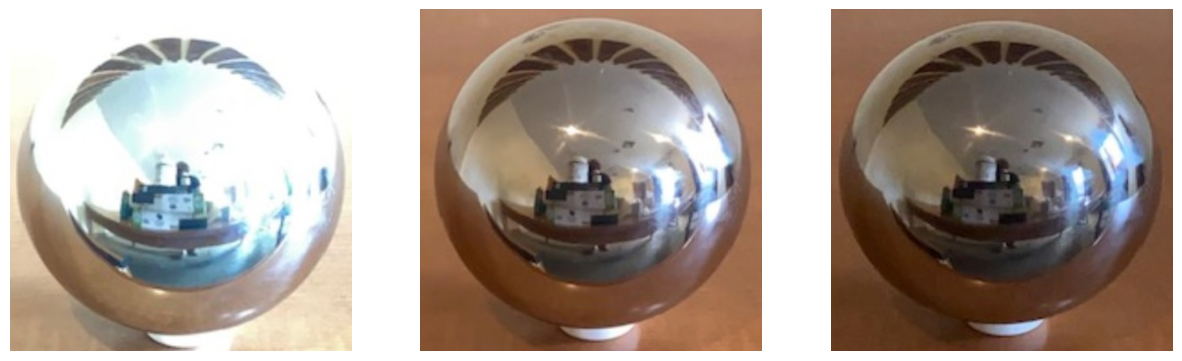

<Figure size 640x480 with 0 Axes>

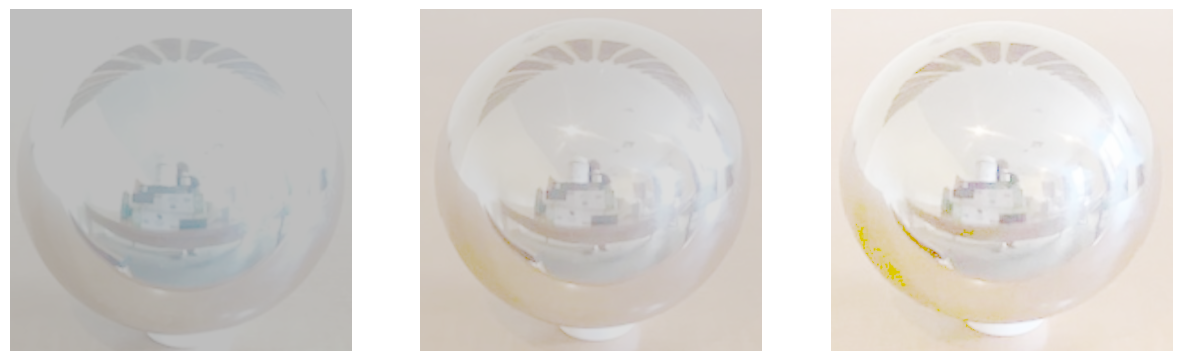

In [ ]:

# get HDR image, log irradiance
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(naive_hdr_image, 'images/outputs/naive_hdr.hdr')

# display HDR image
print('HDR Image')
plt.figure()
display_hdr_image(naive_hdr_image)

# display original images (code provided in utils.display)
plt.figure()
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
plt.figure()
display_images_linear_rescale(naive_log_irradiances)






### Weighted LDR merging 

Compute HDR image as a weighted average of irradiance estimates from LDR images, where weight is based on pixel intensity so that very low/high intensities get less weight


In [ ]:
def make_hdr_weighted(ldr_images: np.ndarray, exposure_times: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) compute weights for images with based on intensities for each exposures
        - This can be a binary mask to exclude low / high intensity values

    2) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    3) Return weighted average of above images
    
    
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposure_times(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions

    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    # TO DO
    w = lambda z: float(128-abs(z-128))

    images = ldr_images.copy()
    hdr_image = np.zeros((H,W,3))
    log_irradiances = np.zeros((N,H,W,3))

    #Create the mask
    mask = np.zeros((N,H,W,3))
    for index in range(N):
      for channel in range(C):
        for x in range(W):
          for y in range(H):
            mask[index,y,x,channel] = w(images[index,y,x,channel]*255)/255
    
    #Steps 2 and 3:
    total = 0
    for index in range(N):
      images[index,:,:,:] /= exposure_times[index]
      total += mask[index,:,:,:]
      hdr_image[:,:,:] += (images[index,:,:,:]*mask[index,:,:,:])
      log_irradiances[index,:,:,:] = np.log(images[index,:,:,:]*mask[index,:,:,:])
    hdr_image /= total
     
    return hdr_image, log_irradiances


<ipython-input-76-8e45a1ae4f88>:49: RuntimeWarning: divide by zero encountered in log
  log_irradiances[index,:,:,:] = np.log(images[index,:,:,:]*mask[index,:,:,:])


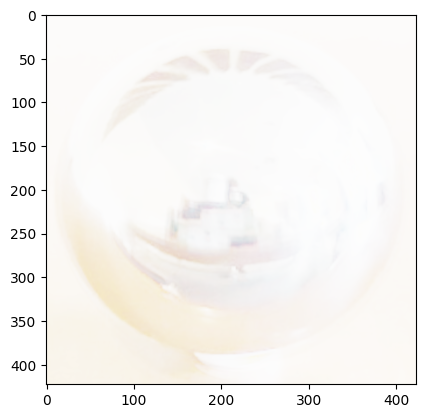

<Figure size 640x480 with 0 Axes>

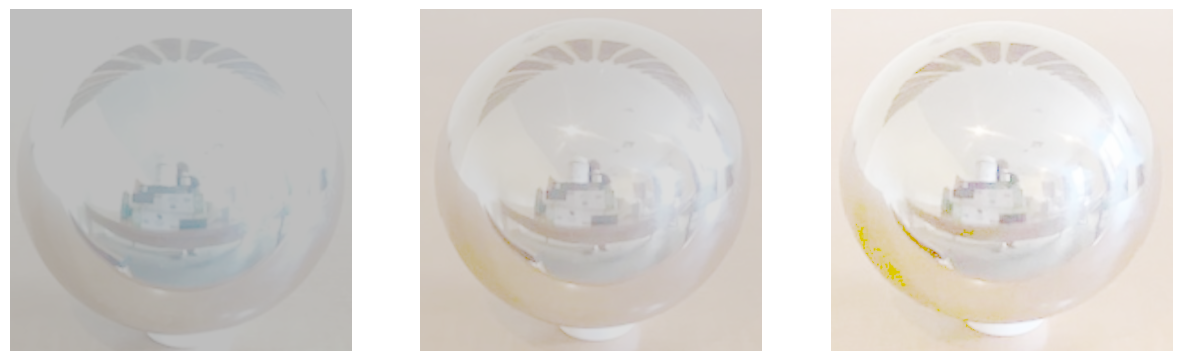

In [ ]:
# get HDR image, log irradiance
weighted_hdr_image, log_irradiance = make_hdr_weighted(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(weighted_hdr_image, 'images/outputs/weighted_hdr.hdr')

# display HDR image
display_hdr_image(weighted_hdr_image)

# display log irradiance image (code provided in utils.display)
plt.figure()
display_images_linear_rescale(naive_log_irradiances)








Min ratio =  0.15862411894919315   Max ratio =  2.6849249777512734


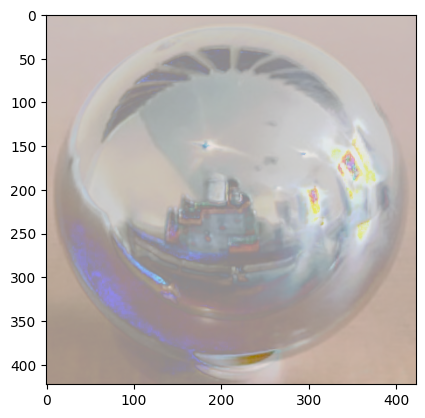

In [ ]:




# display difference between naive and weighted 

log_diff_im = np.log(weighted_hdr_image)-np.log(naive_hdr_image)
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

### LDR merging with camera response function estimation 

Compute HDR after calibrating the photometric reponses to obtain more accurate irradiance estimates from each image

Some suggestions on using <tt>gsolve</tt>:
<ul>
	<li>When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (1000 or so can suffice), but make sure all pixel locations are the same for each exposure.</li>
	<li>The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method).</li>
	<li>Try different lambda values for recovering <i>g</i>. Try lambda=1 initially, then solve for <i>g</i> and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.</li>
	<li>Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log irradiance values, so make sure to exponentiate the result and save irradiance in linear scale.</li>
</ul>

In [ ]:
def make_hdr_estimation(ldr_images: np.ndarray, exposure_times: list, lm)-> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    **IMPORTANT**
    The gsolve operations should be ran with:
        Z: int64 array of shape N x P, where N = number of images, P = number of pixels
        B: float32 array of shape N, log shutter times
        l: lambda; float to control amount of smoothing
        w: function that maps from float intensity to weight  
    The steps to implement:
    1) Create random points to sample (from mirror ball region)
    2) For each exposures, compute g values using samples
    3) Recover HDR image using g values
    

    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
        lm (scalar): the smoothing parameter
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            gsolve
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
        (np.ndarray): 3 x 256 shaped numpy array representing g values of each pixel intensities
            at each channels (used for plotting)
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    
    # TO DO: implement HDR estimation using gsolve
    # gsolve(Z, B, l, w) -> g, lE

    w = lambda z: float(128-abs(z-128))
    hdr_image = np.zeros((H,W,3))
    log_irradiances = np.zeros((N,H,W,3))
    g_values = np.zeros((3,256))

    P = 1000    #The number of points to sample from      
    Z = np.zeros((N,P))
    B = np.log(exposure_times).astype(np.float32)
    l = lm

    for channel in range(3):
      rand_x = np.random.randint(W, size = P, dtype = 'int')  #Randomly sample x
      rand_y = np.random.randint(H, size = P, dtype = 'int')  #Randomly sample y
      for image in range(N):
        for index in range(P):  
          Z[image,index] = int(ldr_images[image,rand_y[index],rand_x[index],channel]*255)
      g, lE = gsolve(Z, B, l, w)
      g_values[channel] = g
      #Compute equation 6 for each pixel:
      print("Channel ", channel)
      for y in range(H):
        for x in range(W):
          top = 0
          bottom = 0
          #Loop through each image
          for image in range(N):
            Zij = int(ldr_images[image,y,x,channel]*255)
            top += (w(Zij))*(g[Zij]-B[image])
            bottom += w(Zij)
            log_irradiances[image,y,x,channel] = g[Zij] - B[image]
          hdr_image[y,x,channel] = np.exp(top/bottom)
    return hdr_image, log_irradiances, g_values


Channel  0
Channel  1
Channel  2


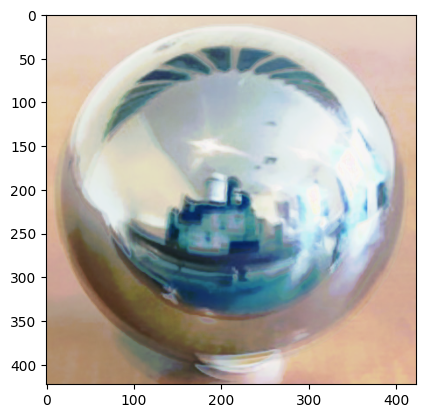

In [ ]:
lm = 2000
# get HDR image, log irradiance
calib_hdr_image, calib_log_irradiances, g = make_hdr_estimation(ldr_images, exposure_times, lm)

# write HDR image to directory
write_hdr_image(calib_hdr_image, 'images/outputs/calib_hdr.hdr')

# display HDR image
display_hdr_image(calib_hdr_image)


Min ratio =  0.034474295522437116   Max ratio =  3.7438302868076865


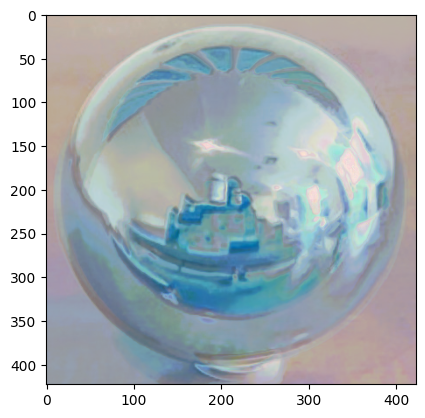

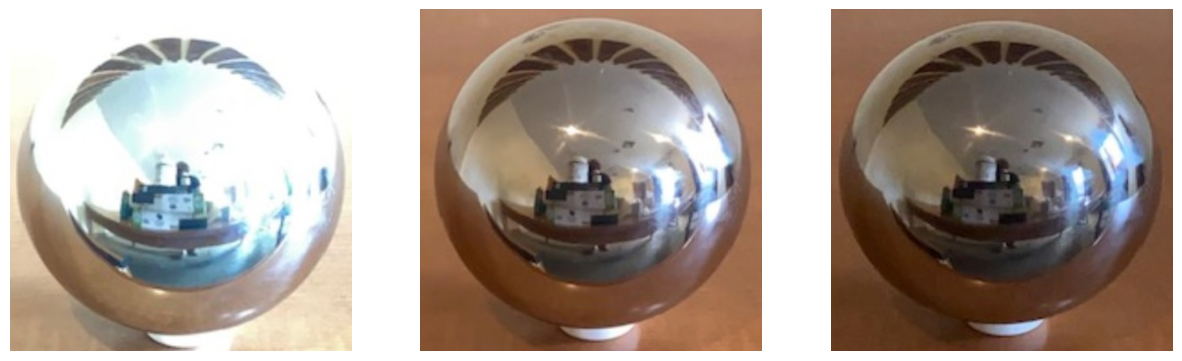

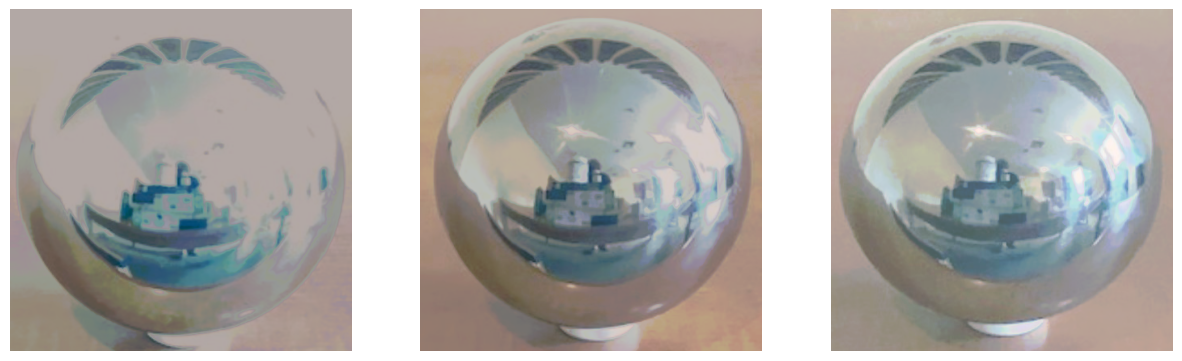

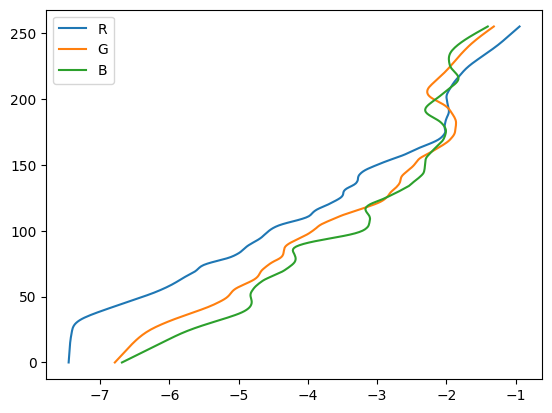

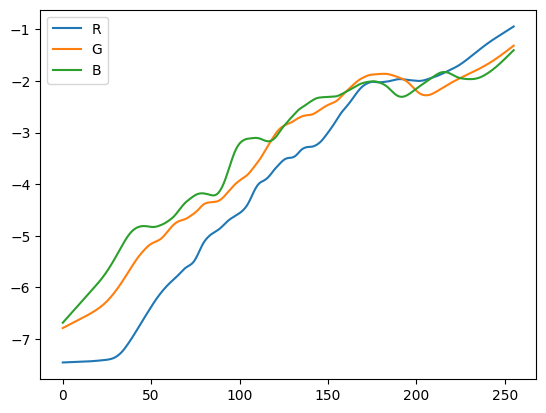

In [ ]:




# display difference between calibrated and weighted
log_diff_im = np.log(calib_hdr_image/calib_hdr_image.mean())-np.log(weighted_hdr_image/weighted_hdr_image.mean())
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(calib_log_irradiances)

# plot g vs intensity, and then plot intensity vs g
N, NG = g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

naive:  	log range =  4.142 	avg RMS error =  0.745
weighted:	log range =  4.175 	avg RMS error =  0.718
calibrated:	log range =  7.749 	avg RMS error =  0.394


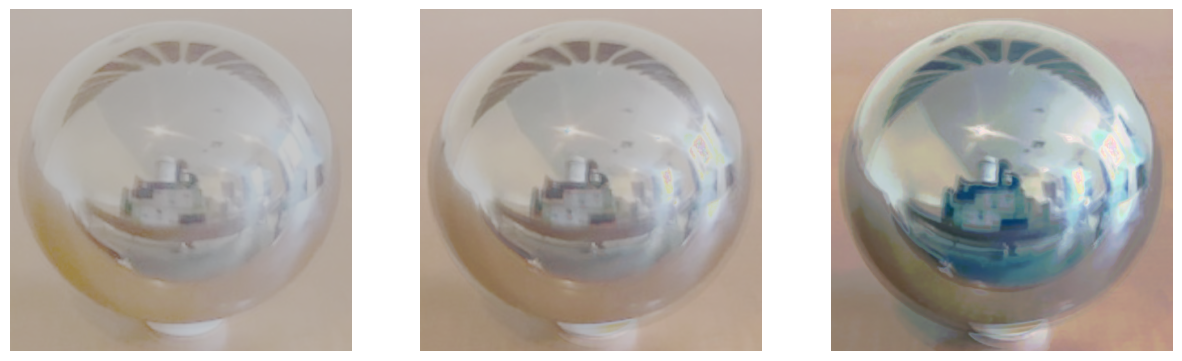

In [ ]:





def weighted_log_error(ldr_images, hdr_image, log_irradiances):
  # computes weighted RMS error of log irradiances for each image compared to final log irradiance
  N, H, W, C = ldr_images.shape
  w = 1-abs(ldr_images - 0.5)*2
  err = 0
  for n in np.arange(N):
    err += np.sqrt(np.multiply(w[n], (log_irradiances[n]-np.log(hdr_image))**2).sum()/w[n].sum())/N 
  return err


# compare solutions
err = weighted_log_error(ldr_images, naive_hdr_image, naive_log_irradiances)
print('naive:  \tlog range = ', round(np.log(naive_hdr_image).max() - np.log(naive_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, weighted_hdr_image, naive_log_irradiances)
print('weighted:\tlog range = ', round(np.log(weighted_hdr_image).max() - np.log(weighted_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, calib_hdr_image, calib_log_irradiances)
print('calibrated:\tlog range = ', round(np.log(calib_hdr_image).max() - np.log(calib_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))

# display log hdr images (code provided in utils.display)
display_images_linear_rescale(np.log(np.stack((naive_hdr_image/naive_hdr_image.mean(), weighted_hdr_image/weighted_hdr_image.mean(), calib_hdr_image/calib_hdr_image.mean()), axis=0)))

## Panoramic transformations 

Compute the equirectangular image from the mirrorball image

In [ ]:



import math

def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image, 
    
    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.
    
    Steps to implement:
    1) Compute N image of normal vectors of mirror ball
    2) Compute R image of reflection vectors of mirror ball
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.
    
    Steps 3 and 4 are implemented for you with get_equirectangular_image

    '''
    H, W, C = hdr_image.shape
    assert H == W
    assert C == 3

    V = np.array([0,0,-1])      #The viewing vector, assumed to be constant

    # TO DO: compute N and R
        
    # R = V - 2 * dot(V,N) * N

    center_x = W/2
    center_y = H/2

    R = np.zeros((H,W,3))
    N = np.zeros((H,W,3))
    # for channel in range(3):
    for u in range(W):
      for v in range(H):
        #Normalize coordinates
        nx = (u - center_x)/(W/2)
        ny = (v - center_y)/(H/2)

        # distance = math.sqrt((u - center_x)**2 + (v - center_y)**2)
        if (1 - (nx**2) - (ny**2) < 0):     #Outside of the sphere
          normal = np.array([0,0,0])
          reflection = np.array([0,0,0])
        else:
          nz = math.sqrt(1 - (nx**2) - (ny**2))
          normal = np.array([nx,ny,nz])             #normal vector
          reflection = V - 2 * np.dot(V,normal) * normal      #reflection vector
        #Map reflection vector to spherical coordinates
        N[v,u,:] = normal
        R[v,u,:] = reflection

    plt.imshow((N+1)/2)
    plt.show()
    plt.imshow((R+1)/2)
    plt.show()

    equirectangular_image = get_equirectangular_image(R, hdr_image)
    return equirectangular_image

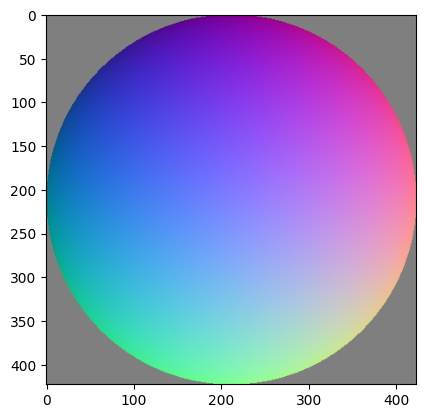

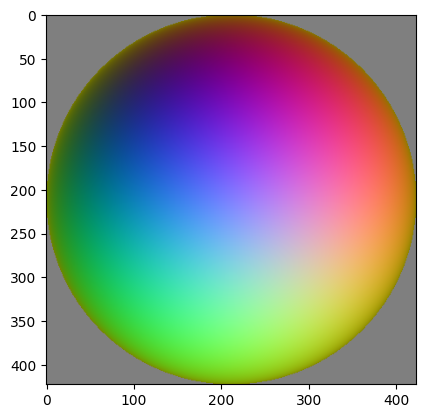

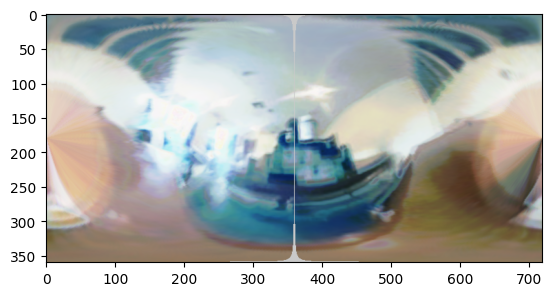

In [86]:
# hdr_mirrorball_image = read_hdr_image('images/outputs/calib_hdr.hdr')
eq_image = panoramic_transform(calib_hdr_image)
 
write_hdr_image(eq_image, 'images/outputs/equirectangular.hdr')

plt.figure()
display_hdr_image(eq_image)


## Rendering synthetic objects into photographs 

Use Blender to render the scene with and with objects and obtain the mask image.  The code below should then load the images and create the final composite.

In [81]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image('/content/drive/MyDrive/CS445/Project 4/Images/rendered_with_objects.png')
E = read_image('/content/drive/MyDrive/CS445/Project 4/Images/rendered_geomertry.png')
M = read_image('/content/drive/MyDrive/CS445/Project 4/Images/blender_mask.png')
M = M > 0.5
I = read_image('/content/drive/MyDrive/CS445/Project 4/samples/background_image.jpg')
I = cv2.resize(I, (M.shape[1], M.shape[0]))

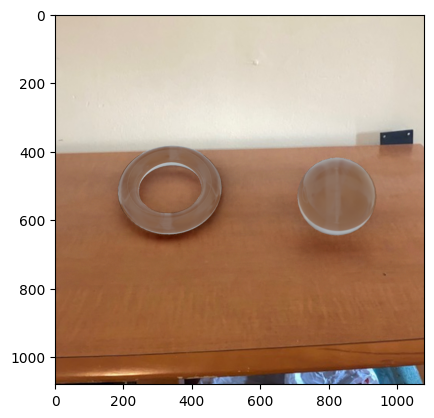

In [85]:
# TO DO: compute final composite
c = 5
result = M*O + (1-M)*I + (1-M)*(O-E)*c

plt.figure()
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_composite.png')